In [1]:
import os
import sys

import math
import numpy
import networkx

import matplotlib.pyplot

sys.path.append("/home/kubicaj/Software/GBA-centrality")
import data_parser

/home/kubicaj/pyenvs/pyEnv_GBA-centrality/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def parse_scores(scores_file):
    '''
    Loads the scores generated with GBA_centrality.py
    
    returns:
    - ENSG2score: dict with key=ENSG, value=score
    - gene2ENSG: dict with key=gene, value=ENSG
    - ENSG2gene: dict key=ENSG, value=gene
    '''
    ENSG2score = {}
    gene2ENSG = {}
    ENSG2gene = {}

    try:
        f = open(scores_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided scores file")

    line = f.readline()
    if not line.startswith("ENSG\t"):
        raise Exception("Scores file problem")

    for line in f:
        split_line = line.rstrip().split('\t')
        ENSG, gene, score = split_line

        ENSG2score[ENSG] = float(score)
        gene2ENSG[gene] = ENSG
        ENSG2gene[ENSG] = gene

    return(ENSG2score, gene2ENSG, ENSG2gene)

In [ ]:
def parse_GBA_ranks(ranks_file):
    '''
    Loads the ranks generated with run_GBA_centrality/leave_one_out.py --ranks
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    - gene2ENSG: dict with key=gene, value=ENSG
    - ENSG2gene: dict key=ENSG, value=gene
    '''
    ENSG2rank = {}
    gene2ENSG = {}
    ENSG2gene = {}

    try:
        f = open(ranks_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided ranks file")

    line = f.readline()
    if not line.startswith("ENSG\t"):
        raise Exception("Ranks file problem")

    for line in f:
        split_line = line.rstrip().split('\t')

        ENSG, gene, rank = split_line

        ENSG2rank[ENSG] = int(rank)
        gene2ENSG[gene] = ENSG
        ENSG2gene[ENSG] = gene

    return(ENSG2rank, gene2ENSG, ENSG2gene)

In [ ]:
def parse_RWR_ranks(ranks_file):
    '''
    Loads the ranks generated with run_MultiXrank/run_leave_one_out.py
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    '''
    ENSG2rank = {}

    try:
        f = open(ranks_file, 'r')
    except Exception as e:
        raise Exception("cannot open provided ranks file")

    for line in f:
        split_line = line.rstrip().split('\t')
        ENSG, rank = split_line
        ENSG2rank[ENSG] = int(rank)

    return(ENSG2rank)

In [5]:
def calculate_PageRank_ranks(causal_genes, interactome, alpha):
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

    # causal_genes: dict of causal genes with key=ENSG, value=1
    causal_genes = causal_genes.copy()
    for left_out in causal_genes:
        causal_genes[left_out] = 1

    ENSG2rank_pagerank = {}
    for left_out in list(causal_genes.keys()):
        del causal_genes[left_out]

        # calculate PageRank scores
        res_pagerank = networkx.pagerank(interactome, personalization=causal_genes, alpha=alpha)

        # save the left-out rank
        results_sorted = sorted(res_pagerank.keys(), key=lambda item: res_pagerank[item], reverse=True)
        rank_left_out = results_sorted.index(left_out) + 1  # + 1 because ranks start at 1 not 0
        ENSG2rank_pagerank[left_out] = rank_left_out

        # add left-out back to causal_genes
        causal_genes[left_out] = 1

    return(ENSG2rank_pagerank)

In [26]:
def generate_random_ranks(interactome, ENSG2rank_RWR):
    # generate ranks with a random classifier
    # use the integers method of a Generator instance instead of numpy.random.randint
    # https://numpy.org/doc/2.1/reference/random/generated/numpy.random.randint.html
    rng = numpy.random.default_rng()

    # 1D numpy array for left-out known causal gene ranks
    # size=len(left-out genes)
    ranks_random = numpy.zeros(len(ENSG2rank_RWR), dtype=numpy.uint64)

    n = 10000
    for i in range(n):
        # 1D numpy array for left-out gene ranks
        # size=len(left-out genes)
        tmp = rng.integers(low=1, high=len(interactome), size=ranks_random.shape, dtype=numpy.uint64)
        tmp = numpy.sort(tmp)
        ranks_random += tmp

    for j in range(len(ranks_random)):
        avg_rank = ranks_random[j] / n
        ranks_random[j] = avg_rank

    return ranks_random

In [27]:
'''Set path for output figures if needed'''
SAVE_FIGURES = True
FIGURES_DIR = "./figures/"

### Testing different alpha values

In [28]:
'''Set parameters with which the methods were run'''
PHENOTYPE = "MMAF" # to choose from: MMAF, NOA, DILCARD, HYPCARD, BC (breast cancer), CC (colon cancer)
ALPHAS = [0.3, 0.5, 0.7]
WEIGHTED = False
DIRECTED = False

In [29]:
INTERACTOME_FILE = "/home/kubicaj/GBA-input/interactome_human.sif"

In [30]:
'''Parse interactome and construct interactome: networkx Graph'''
(edge_list, ENSG2idx, idx2ENSG) = data_parser.parse_interactome(interactome_file=INTERACTOME_FILE, weighted=WEIGHTED, directed=DIRECTED)

edge_list_no_weights = []
for edge in edge_list:
    edge_list_no_weights.append((idx2ENSG[edge[0]], idx2ENSG[edge[1]]))
interactome = networkx.from_edgelist(edge_list_no_weights)

print(f"Interactome: {len(interactome.nodes())} proteins, {len(interactome.edges())} interactions")

Interactome: 16763 proteins, 255066 interactions


No handles with labels found to put in legend.


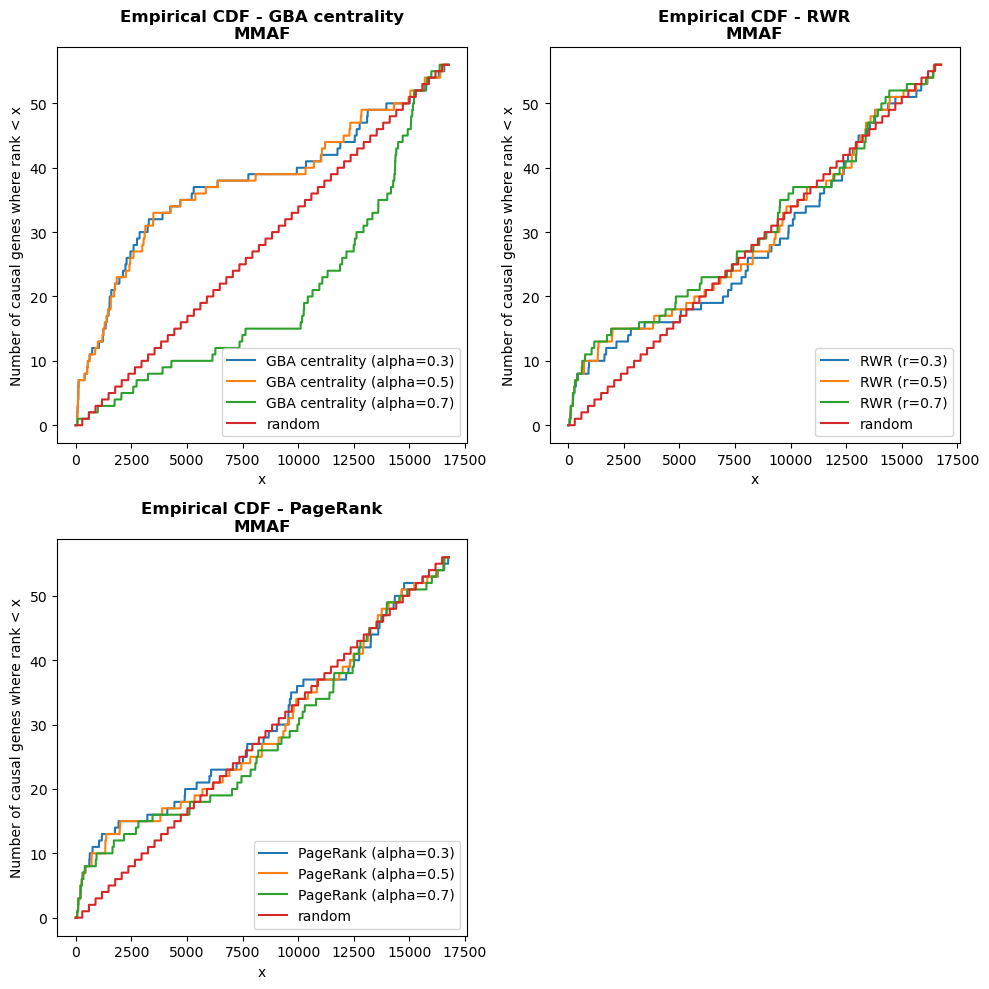

In [ ]:
columns = 2
rows = math.ceil(3 / columns)  # number of methods = 3

fig, ax = matplotlib.pyplot.subplots(rows, columns, figsize=(columns * 5, rows * 5))
ax = ax.flatten()

for param in ALPHAS:
    ALPHA = param
    alpha = str(ALPHA).replace('.', '')

    if ALPHA == 0.5:
        ENSG2rank_RWR = parse_RWR_ranks(f"/home/kubicaj/GBA-centrality-validation/run_MultiXrank/{PHENOTYPE}/RWR_ranks_LOO.tsv")
    else:
        ENSG2rank_RWR = parse_RWR_ranks(f"/home/kubicaj/GBA-centrality-validation/run_MultiXrank/{PHENOTYPE}/r{alpha}/RWR_ranks_LOO.tsv")
    ENSG2rank_GBA, _, _ = parse_GBA_ranks(f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/ranks_LOO.tsv")
    ENSG2rank_pagerank = calculate_PageRank_ranks(causal_genes=ENSG2rank_GBA, interactome=interactome, alpha=ALPHA)

    ranks_RWR = []
    ranks_GBA = []
    ranks_pagerank = []

    for gene in ENSG2rank_RWR:
        ranks_RWR.append(ENSG2rank_RWR[gene])
        ranks_GBA.append(ENSG2rank_GBA[gene])
        ranks_pagerank.append(ENSG2rank_pagerank[gene])

    curve_RWR = []
    curve_GBA = []
    curve_pagerank = []
    
    for i in range(len(interactome)):
        curve_RWR.append(sum(rank <= i for rank in ranks_RWR))
        curve_GBA.append(sum(rank <= i for rank in ranks_GBA))
        curve_pagerank.append(sum(rank <= i for rank in ranks_pagerank))

    ax[0].plot(range(len(interactome)), curve_GBA, label=f"GBA centrality (alpha={ALPHA})")
    ax[1].plot(range(len(interactome)), curve_RWR, label=f"RWR (r={ALPHA})")
    ax[2].plot(range(len(interactome)), curve_pagerank, label=f"PageRank (1-alpha={ALPHA})")

    # Title based on phenotype
    title_map = {
        "MMAF": PHENOTYPE,
        "NOA": PHENOTYPE,
        "OG": PHENOTYPE,
        "PCD": PHENOTYPE,
        "POF": PHENOTYPE,
        "BC": "breast cancer",
        "CC": "colon cancer",
        "HYPCARD": "hypertrophic cardiomyopathy",
        "DILCARD": "dilated cardiomyopathy"
    }
    ax[0].set_title(f"Empirical CDF - GBA centrality\n{title_map.get(PHENOTYPE, PHENOTYPE)}", fontsize=12, weight='bold')
    ax[1].set_title(f"Empirical CDF - RWR\n{title_map.get(PHENOTYPE, PHENOTYPE)}", fontsize=12, weight='bold')
    ax[2].set_title(f"Empirical CDF - PageRank\n{title_map.get(PHENOTYPE, PHENOTYPE)}", fontsize=12, weight='bold')

# calculate random ranks
ranks_random = generate_random_ranks(interactome, ENSG2rank_RWR)
curve_random = []
for i in range(len(interactome)):
    curve_random.append(sum(rank <= i for rank in ranks_random))

ax[0].plot(range(len(interactome)), curve_random, label="random")
ax[1].plot(range(len(interactome)), curve_random, label="random")
ax[2].plot(range(len(interactome)), curve_random, label="random")

for a in ax:
    a.set_xlabel("x")
    a.set_ylabel("Number of causal genes where rank < x")
    a.legend(loc="lower right")

# hide unused subplots (if number of images < grid size)
for i in range(len(ALPHAS), len(ax)):
    fig.delaxes(ax[i])

matplotlib.pyplot.tight_layout()
if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"compare_alpha_CDF_{PHENOTYPE}", dpi=1000)

### Testing threshold for scores convergence

In [33]:
'''Set parameters with which GBA_centrality.py was run'''
PHENOTYPE = "MMAF"
ALPHA = 0.5
alpha = str(ALPHA).replace('.', '')
THRESHOLDS = ["1e-2", "1e-3", "1e-4", "1e-5", "1e-6"]

#### 1) MMAF + interactome

In [34]:
ENSG2scores = {}  # key=ENSG, value=list[scores for different THRESHOLDS]
threshold2scores = {}  # key=threshold, value=list[scores for ENSG]

for THRESHOLD in THRESHOLDS:
    RESULTS_FILE = f"/home/kubicaj/GBA-output/{PHENOTYPE}/alpha{alpha}/scores_{THRESHOLD}.tsv"
    ENSG2score, gene2ENSG, ENSG2gene = parse_scores(RESULTS_FILE)

    for ENSG in ENSG2score:
        if ENSG not in ENSG2scores:
            ENSG2scores[ENSG] = []
        ENSG2scores[ENSG].append(ENSG2score[ENSG])
    
    threshold2scores[THRESHOLD] = list(ENSG2score.values())

In [35]:
# save ENSG2scores to TSV with header: ENSG THRESHOLD_1e-2 THRESHOLD_1e-3 ...
COMPARE_SCORES_FILE = f"./run_GBA_centrality/compare_scores_{PHENOTYPE}.tsv"

threshlods = "\t".join(THRESHOLDS)
with open(COMPARE_SCORES_FILE, 'w') as f:
    f.write(f"ENSG\t{threshlods}\n")
    for ENSG in ENSG2scores:
        scores = "\t".join([str(score) for score in ENSG2scores[ENSG]])
        f.write(ENSG + "\t" + scores + "\n")

Threshold 1e-2: mean score = 0.0053
Threshold 1e-3: mean score = 0.0054
Threshold 1e-4: mean score = 0.0054
Threshold 1e-5: mean score = 0.0054
Threshold 1e-6: mean score = 0.0054


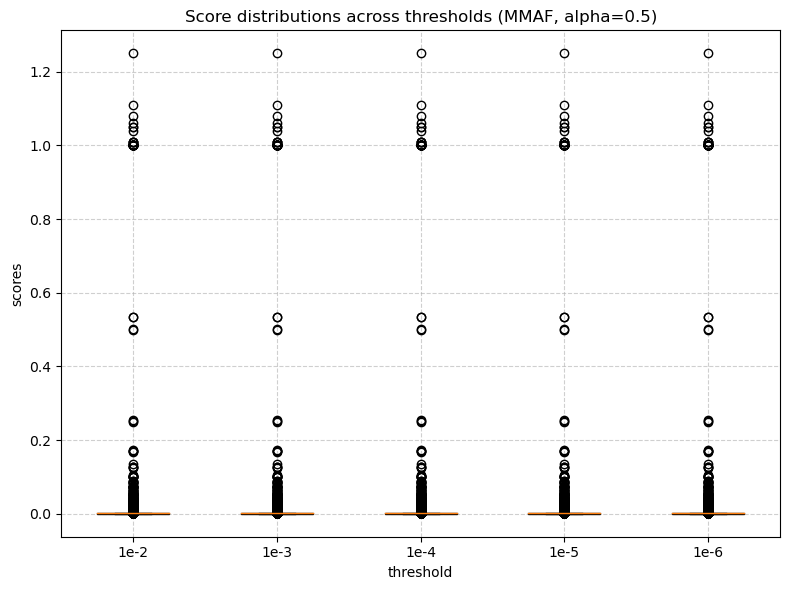

In [36]:
# calculate average score per threshold
threshold2mean = {th: numpy.mean(scores) for th, scores in threshold2scores.items()}

for th, mean_val in threshold2mean.items():
    print(f"Threshold {th}: mean score = {mean_val:.4f}")

# plot
fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))

data = [threshold2scores[th] for th in THRESHOLDS]

ax.boxplot(data, labels=THRESHOLDS, patch_artist=True)

ax.set_xlabel("threshold")
ax.set_ylabel("scores")
ax.set_title(f"Score distributions across thresholds ({PHENOTYPE}, alpha={ALPHA})")
ax.grid(True, linestyle="--", alpha=0.6)

matplotlib.pyplot.tight_layout()
if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"compare_thresholds_{PHENOTYPE}.png", dpi=1000)
matplotlib.pyplot.show()

#### 2) subnetwork ZMYND-TTC-SLC-neighbors + ZMYND-TTC as causal

In [37]:
ENSG2scores = {}  # key=ENSG, value=list[scores for different THRESHOLDS]
threshold2scores = {}  # key=threshold, value=list[scores for ENSG]

for THRESHOLD in THRESHOLDS:
    RESULTS_FILE = f"/home/kubicaj/GBA-output/testSubnetworkZMYND-TTC/scores_{THRESHOLD}.tsv"
    ENSG2score, gene2ENSG, ENSG2gene = parse_scores(RESULTS_FILE)

    for ENSG in ENSG2score:
        if ENSG not in ENSG2scores:
            ENSG2scores[ENSG] = []
        ENSG2scores[ENSG].append(ENSG2score[ENSG])
    
    threshold2scores[THRESHOLD] = list(ENSG2score.values())

In [38]:
# save ENSG2scores to TSV with header: ENSG THRESHOLD_1e-2 THRESHOLD_1e-3 ...
COMPARE_SCORES_FILE = f"./run_GBA_centrality/compare_scores_SubnetworkZMYND-TTC.tsv"

threshlods = "\t".join(THRESHOLDS)
with open(COMPARE_SCORES_FILE, 'w') as f:
    f.write(f"ENSG\t{threshlods}\n")
    for ENSG in ENSG2scores:
        scores = "\t".join([str(score) for score in ENSG2scores[ENSG]])
        f.write(ENSG + "\t" + scores + "\n")

Threshold 1e-2: mean score = 0.2728
Threshold 1e-3: mean score = 0.2730
Threshold 1e-4: mean score = 0.2731
Threshold 1e-5: mean score = 0.2731
Threshold 1e-6: mean score = 0.2731


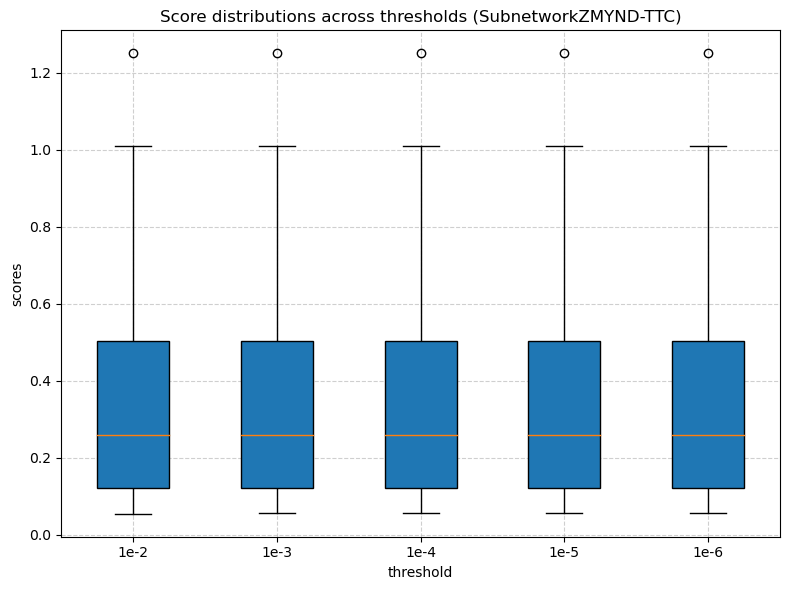

In [39]:
# calculate average score per threshold
threshold2mean = {th: numpy.mean(scores) for th, scores in threshold2scores.items()}

for th, mean_val in threshold2mean.items():
    print(f"Threshold {th}: mean score = {mean_val:.4f}")

# plot
fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))

data = [threshold2scores[th] for th in THRESHOLDS]

ax.boxplot(data, labels=THRESHOLDS, patch_artist=True)

ax.set_xlabel("threshold")
ax.set_ylabel("scores")
ax.set_title(f"Score distributions across thresholds (SubnetworkZMYND-TTC)")
ax.grid(True, linestyle="--", alpha=0.6)

matplotlib.pyplot.tight_layout()
if SAVE_FIGURES:
    matplotlib.pyplot.savefig(FIGURES_DIR + f"compare_thresholds_SubnetworkZMYND-TTC.tsv.png", dpi=1000)
matplotlib.pyplot.show()